참고: https://zzsza.github.io/data/2018/08/30/google-colab/

# 개요

서울대 RNN2 학습/검증

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-rc1
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import IPython.display as display
import pandas as pd
import datetime
import os
import time
import numpy as np
import glob
import pathlib
!pip3 install gcsfs dask
import gcsfs
import json
from sklearn.utils import shuffle
import tensorflow.keras as keras
import tensorflow.keras.activations as act
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
import matplotlib.pyplot as plt

     |████████████████████████████████| 380.5MB 40kB/s 
     |████████████████████████████████| 501kB 34.5MB/s 
     |████████████████████████████████| 4.3MB 52.5MB/s 


In [ ]:
# 유닉스 정보 조회
!cat /etc/issue.net

Ubuntu 18.04.3 LTS


In [ ]:
!nvidia-smi

Fri Dec  6 00:46:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!grep -c processor /proc/cpuinfo

4


## 구글 드라이브 마운트

구글 계정에 인증을 물어온다. 두번 물어 올 수 있음.

내 구글 드라이브의 폴더를 colab에 마운트 할 수 있다.

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!gcloud auth list

      Credentialed Accounts
ACTIVE  ACCOUNT
*       jangmin.o@wemakeprice.com

To set the active account, run:
    $ gcloud config set account `ACCOUNT`



In [ ]:
base_path = pathlib.Path('gdrive/My Drive/snu_project')
BATCH_SIZE=4

빅쿼리에서 데이터 로딩 (일회성)

In [ ]:
%env GOOGLE_CLOUD_PROJECT=eighth-edge-810

env: GOOGLE_CLOUD_PROJECT=eighth-edge-810


In [ ]:
%%bigquery prod_df
SELECT prod_no, prod_nm, prod2i, mcate_cd, mcate2i FROM `eighth-edge-810.wmind_datamart.snu_ordered_prod_info_20191126`

In [ ]:
prod_df.to_pickle(str(base_path.joinpath('ordered_prod_info.pkl.gz')), 'gzip')

In [ ]:
%%bigquery train_df
SELECT mid, train_data as data FROM `eighth-edge-810.wmind_datamart.snu_instances_20191126`, unnest(train) as train_data

In [ ]:
train_df['data'] = train_df.data.apply(lambda x: json.loads(x))
train_df = shuffle(train_df)
train_df.to_pickle(str(base_path.joinpath('train.pkl.gz')), 'gzip')

In [ ]:
%%bigquery valid_df
SELECT mid, valid_data as data FROM `eighth-edge-810.wmind_datamart.snu_instances_20191126`, unnest(valid) as valid_data

In [ ]:
valid_df['data'] = valid_df.data.apply(lambda x: json.loads(x))
valid_df = shuffle(valid_df)
valid_df.to_pickle(str(base_path.joinpath('validation.pkl.gz')), 'gzip')

In [ ]:
%%bigquery test_df
SELECT mid, test_data as data FROM `eighth-edge-810.wmind_datamart.snu_instances_20191126`, unnest(test) as test_data

In [ ]:
test_df['data'] = test_df.data.apply(lambda x: json.loads(x))
test_df = shuffle(test_df)
test_df.to_pickle(str(base_path.joinpath('test.pkl.gz')), 'gzip')

TF에 넣을 데이터만 추림

In [ ]:
train_df = pd.read_pickle(str(base_path.joinpath('train.pkl.gz')))

In [ ]:
x = train_df.data.apply(lambda x: np.concatenate((np.array(x['prod2is'],dtype=np.int32).reshape((-1, 1)), np.array(x['mcate2is'],dtype=np.int32).reshape((-1, 1))), axis=1 ))
y = train_df.data.apply(lambda x: np.int32(x['label']))
train_data_df = pd.concat([train_df.mid, x.rename('x'), y.rename('label')], axis=1)
train_data_df.to_pickle(str(base_path.joinpath('train_data_df.pkl.gz')), 'gzip')

In [ ]:
train_data_df.x.iloc[1]

array([[943059,    374],
       [943821,     45],
       [947422,    192],
       [950139,    368],
       [945437,    372],
       [937926,     27],
       [807501,    199],
       [953043,     68]], dtype=int32)

In [ ]:
valid_df = pd.read_pickle(str(base_path.joinpath('validation.pkl.gz')))

In [ ]:
x = valid_df.data.apply(lambda x: np.concatenate((np.array(x['prod2is'],dtype=np.int32).reshape((-1, 1)), np.array(x['mcate2is'],dtype=np.int32).reshape((-1, 1))), axis=1 ))
y = valid_df.data.apply(lambda x: np.int32(x['label']))
valid_data_df = pd.concat([valid_df.mid, x.rename('x'), y.rename('label')], axis=1)
valid_data_df.to_pickle(str(base_path.joinpath('valid_data_df.pkl.gz')), 'gzip')

In [ ]:
test_df = pd.read_pickle(str(base_path.joinpath('test.pkl.gz')))

In [ ]:
x = test_df.data.apply(lambda x: np.concatenate((np.array(x['prod2is'],dtype=np.int32).reshape((-1, 1)), np.array(x['mcate2is'],dtype=np.int32).reshape((-1, 1))), axis=1 ))
y = test_df.data.apply(lambda x: np.int32(x['label']))
test_data_df = pd.concat([test_df.mid, x.rename('x'), y.rename('label')], axis=1)
test_data_df.to_pickle(str(base_path.joinpath('test_data_df.pkl.gz')), 'gzip')

fasttext를 수행할 타이틀 추출

In [ ]:
prod_df.prod_nm.to_csv(str(base_path.joinpath('prod_nms.csv')), index=False, header=False)

In [ ]:
!gsutil -m cp 'gdrive/My Drive/snu_project/*' gs://recom-test/snu_project

Copying file://gdrive/My Drive/snu_project/ordered_prod_info.pkl.gz [Content-Type=application/octet-stream]...
Copying file://gdrive/My Drive/snu_project/validation.pkl.gz [Content-Type=application/octet-stream]...
Copying file://gdrive/My Drive/snu_project/test.pkl.gz [Content-Type=application/octet-stream]...
Copying file://gdrive/My Drive/snu_project/test_data_df.pkl.gz [Content-Type=application/octet-stream]...
Copying file://gdrive/My Drive/snu_project/train.pkl.gz [Content-Type=application/octet-stream]...
Copying file://gdrive/My Drive/snu_project/train_data_df.pkl.gz [Content-Type=application/octet-stream]...
Copying file://gdrive/My Drive/snu_project/prod_nms.csv [Content-Type=text/csv]...
Copying file://gdrive/My Drive/snu_project/valid_data_df.pkl.gz [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"paralle

In [ ]:
!gsutil -m cp gs://recom-test/snu_project/prod_emb_mat.npy 'gdrive/My Drive/snu_project/fasttext'

Copying gs://recom-test/snu_project/prod_emb_mat.npy...
| [1/1 files][472.0 MiB/472.0 MiB] 100% Done  43.6 MiB/s ETA 00:00:00           
Operation completed over 1 objects/472.0 MiB.                                    


이후 여기부터 시작

- D: embedding dimension
- P: # or products
- M: # or mcate
- B: BATCH_SIZE

In [ ]:
%%time
train_data_df = pd.read_pickle(str(base_path.joinpath('train_data_df.pkl.gz')))
valid_data_df = pd.read_pickle(str(base_path.joinpath('valid_data_df.pkl.gz')))

CPU times: user 11.1 s, sys: 1.16 s, total: 12.3 s
Wall time: 13.7 s


In [ ]:
prod_df = pd.read_pickle(str(base_path.joinpath('ordered_prod_info.pkl.gz')))
prod_df = prod_df.sort_values(by=['prod2i']).set_index('prod2i')

In [ ]:
P = prod_df.shape[0]
M = prod_df.mcate2i.value_counts().shape[0]
D = 128
B = BATCH_SIZE

임베딩 행렬 로딩: shape==[P, D]

In [ ]:
np_prod_embedding = np.load(str(base_path.joinpath("fasttext").joinpath("prod_emb_mat.npy")))

In [ ]:
np_prod_embedding

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09749427,  0.0040447 , -0.15179805, ...,  0.01083633,
        -0.07715385, -0.06197934],
       [ 0.07218083, -0.01890226, -0.19205369, ...,  0.01039626,
        -0.05714676, -0.04734085],
       ...,
       [-0.0528723 , -0.00954199, -0.07857933, ..., -0.07444088,
        -0.15658966,  0.00219295],
       [-0.00745197, -0.06100256,  0.04682942, ...,  0.02340629,
        -0.11738155, -0.04557302],
       [-0.12385555, -0.03802903,  0.0650975 , ..., -0.06814113,
        -0.13313623,  0.01738781]], dtype=float32)

데이터셋

In [ ]:
from functools import partial

In [ ]:
def gen(df):
  for idx, row in df.iterrows():
    yield(row.mid, row.x, row.x.shape[0], row.label)

In [ ]:
ds = tf.data.Dataset.from_generator(partial(gen, train_data_df), (tf.int64, tf.int32, tf.int32, tf.int32), (tf.TensorShape([]), tf.TensorShape([None,2]), tf.TensorShape([]), tf.TensorShape([])) )
ds = ds.padded_batch(BATCH_SIZE, padded_shapes=([], [None, 2], [], []))

In [ ]:
es = next(iter(ds.take(1)))

In [ ]:
es

(<tf.Tensor: id=49, shape=(4,), dtype=int64, numpy=array([ 2303940, 26325442,  1364426, 11454181])>,
 <tf.Tensor: id=50, shape=(4, 8, 2), dtype=int32, numpy=
 array([[[248013,    327],
         [289254,    105],
         [897795,    368],
         [161834,    369],
         [     0,      0],
         [     0,      0],
         [     0,      0],
         [     0,      0]],
 
        [[943059,    374],
         [943821,     45],
         [947422,    192],
         [950139,    368],
         [945437,    372],
         [937926,     27],
         [807501,    199],
         [953043,     68]],
 
        [[940762,     84],
         [945313,    141],
         [941896,    229],
         [947689,     80],
         [945785,    187],
         [949732,    314],
         [949275,    331],
         [950077,    141]],
 
        [[  6177,     83],
         [921423,     83],
         [  4922,     81],
         [  4922,     81],
         [  6177,     83],
         [  4922,     81],
         [     0,      

In [ ]:
model = keras.Sequential([
             layers.Embedding(P+1, D, weights=[np_prod_embedding], mask_zero=True, trainable=False),
             layers.LSTM(5, return_sequences=False)   
              ]
              )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model.call(es[1][:,:, 0])[0]

<tf.Tensor: id=2276, shape=(5,), dtype=float32, numpy=
array([-0.07150709,  0.03244724,  0.03638037,  0.00304948,  0.0632699 ],
      dtype=float32)>

In [ ]:
model2 = keras.Sequential([
             layers.Embedding(M+1, D, mask_zero=True) , 
             layers.GRU(5, return_sequences=True)   
              ]
              )

In [ ]:
model2.call(es[1][:,:, 1])[0]

<tf.Tensor: id=4314, shape=(8, 5), dtype=float32, numpy=
array([[-0.00922142, -0.00215422, -0.00039112, -0.01324965,  0.00112781],
       [-0.02165597,  0.00167335,  0.02558472, -0.00678662,  0.00878757],
       [-0.00644116, -0.01661966, -0.00038713, -0.00288206, -0.01866435],
       [-0.04474729, -0.02402742,  0.03631931,  0.0271406 ,  0.02189269],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)>

## 모델 작성

In [ ]:
def initialize_lstm(num_layers, num_units, decay):
  """
  Initialize LSTM layers.

  :param num_layers: the number of layers.
  :param num_units: the number of hidden units in each cell.
  :param decay: an L2 decay parameter for regularization.
  :return: a sequence of LSTM layers.
  """
  lstm = keras.Sequential()
  for _ in range(num_layers):
    lstm.add(layers.LSTM(num_units, return_sequences=True,
            kernel_regularizer=reg.l2(decay),
            bias_regularizer=reg.l2(decay),
            activation='sigmoid'))
  return lstm

In [ ]:
def initialize_dense_layer(num_units, decay):
  """
  Initialize a dense layer which follows a sequence of LSTM layers.

  :param num_units: the number of units of the output.
  :param decay: an L2 decay parameter for regularization.
  :return: the initialized dense layer.
  """
  return layers.Dense(num_units,
                kernel_regularizer=reg.l2(decay),
                bias_regularizer=reg.l2(decay))


In [ ]:
def initialize_embedding(num_entries, num_units, decay):
  """
  Initialize an embedding layer.

  :param num_entries: the number of entries whose embeddings to be learned.
  :param num_units: the number of units of each embedding.
  :param decay: an L2 decay parameter for regularization.
  :return: the initialized embedding layer.
  """
  embedding = layers.Embedding(
      num_entries, num_units, embeddings_regularizer=reg.l2(decay))
  # embedding(0)  # initialize the embeddings
  return embedding

In [ ]:
def load_pretrained_embedding(numpy_mat, trainable=False):
  """
  Initialize embedding layer initialized from exteranl numpy mat
  """
  embedding = layers.Embedding(
      numpy_mat.shape[0], numpy_mat.shape[1], weights=[numpy_mat], trainable=trainable)
  return embedding  

#### Model

In [ ]:
class Model(keras.Model):
  """
  Abstract model for recommendation.
  """
  is_trainable = None

  def __init__(self, embeddings):
    """
    Class initializer.

    :param embeddings: numpy matrix shape(P+1, D).
    """
    super().__init__()
    self.embeddings = load_pretrained_embedding(embeddings)

  def call(self, inputs, candidates):
    """
    Run forward propagation to produce outputs.

    :param inputs: a tuple of input tensors for predictions.
    :param candidates: a tuple of input tensors for candidates.
    :return: the predicted scores for all candidates.
    """
    pass

  @tf.function
  def _lookup_features(self, seqs):
    """
    Look up the feature vectors of all items in sequences.

    :param seqs: the behavioral sequences for predictions.
    :return: the feature vectors.
    """
    return self.embeddings(seqs)

  @tf.function
  def eval_loss(self, inputs, labels):
    """
    Evaluate the loss value for current inputs.

    :param inputs: a tuple of input tensors for predictions.
    :param labels: true labels of the given inputs.
    :return: the calculated loss.
    """
    return 0.

  @tf.function
  def predict_top_k(self, inputs, candidates, k):
    """
    Return the top K recommendations among given candidates.

    :param inputs: a tuple of input tensors for predictions.
    :param candidates: a tuple of input tensors for candidates.
    :param k: the number of items to recommend.
    :return: the top K items with the highest scores.
    """
    predictions = self.call(inputs, candidates)
    return tf.nn.top_k(predictions, k, sorted=True)

  @tf.function
  def eval_accuracy(self, inputs, candidates, labels, k):
    """
    Evaluate the accuracy of given inputs and labels.

    :param inputs: a tuple of input tensors for predictions.
    :param candidates: a tuple of input tensors for candidates.
    :param labels: true labels of the given inputs.
    :param k: the number of items to recommend.
    :return: the calculated accuracy.
    """
    predictions = self.predict_top_k(inputs, candidates, k)[1]
    compared = tf.equal(tf.expand_dims(labels, axis=1), predictions)
    corrects = tf.reduce_sum(tf.cast(compared, dtype=tf.float32), axis=1)
    return tf.reduce_mean(corrects)

#### BaseModel

In [ ]:
class BaseModel(Model):
  """
  Base model for recommendation, which has no learnable parameters.
  """
  is_trainable = False

  def __init__(self, embeddings, mode='average'):
    """
    Class initializer.

    :param embeddings: embedding vectors of all items.
    :param mode: the prediction mode of this model: average or last.
    """
    super().__init__(embeddings)
    self.mode = mode

  @tf.function
  def call(self, inputs, candidates):
    """
    Run forward propagation to produce outputs.

    :param inputs: a tuple of input tensors for predictions.
    :param candidates: a tuple of input tensors for candidates.
    :return: the predicted scores for all candidates.
    """
    mid, x, len, label = inputs
    orders = x[:, :, 0]
    orders_x = self._lookup_features(orders)
    cands_x = candidates[0]
    len = tf.cast(len, tf.float32)

    if self.mode == 'average':
        out = tf.reduce_sum(orders_x, axis=1)
        out /= tf.expand_dims(len, axis=1)
    elif self.mode == 'last':
        out = orders_x[:, -1, :]
    else:
        raise ValueError(self.mode)
    return tf.matmul(out, cands_x, transpose_b=True)


#### 테스트 BaseModel

In [ ]:
base_model = BaseModel(np_prod_embedding)

In [ ]:
prod_embs = tf.convert_to_tensor(np_prod_embedding, tf.float32)

In [ ]:
candidates = (prod_embs, None)

In [ ]:
#base_model(es, candidates)
base_model.eval_accuracy(es, candidates, es[3], 10)

In [ ]:
np.dot(np_prod_embedding[913305], np_prod_embedding[941960])

0.90099144

#### RNN1

In [ ]:
class RNN1(Model):
  """
  RNN 1 model for recommendation, which uses none of important techniques.
  """
  is_trainable = True

  def __init__(self, embeddings, num_units=32, num_layers=1, decay=0):
    """
    Class initializer.

    :param embeddings: embedding vectors of all items.
    :param num_units: the number of hidden units in each LSTM cell.
    :param num_layers: the number of LSTM layers.
    :param decay: an L2 decay parameter for regularization.
    """
    super().__init__(embeddings)
    self.lstm = initialize_lstm(num_layers, num_units, decay)
    self.linear = initialize_dense_layer(embeddings.shape[1], decay)
    self.samples = 'full'
    self.softmax_bias = tf.zeros(embeddings.shape[0])
    self.categories = None

  @tf.function
  def call(self, inputs, candidates):
    """
    Run forward propagation to produce outputs.

    :param inputs: a tuple of input tensors for predictions.
    :param candidates: a tuple of input tensors for candidates.
    :return: the predicted scores for all candidates.
    """
    users, x, len, orders, clicks = inputs
    orders = self._lookup_features(orders)
    orders = self.lstm(orders)
    clicks = self._lookup_features(clicks)
    out = self._run_attention(users, orders, clicks)
    out = self.linear(out)

    cands_x, cands_c = candidates
    cands_v = self._lookup_candidates(cands_x, cands_c)
    return tf.matmul(out, tf.transpose(cands_v))

  @tf.function
  def train(self, inputs, labels, optimizer):
      """
      Train the current model by a single batch.

      :param inputs: a tuple of input tensors for predictions.
      :param labels: true labels of the given inputs.
      :param optimizer: an optimizer to apply.
      :return: the current training loss.
      """
      with tf.GradientTape() as tape:
          loss = self.eval_loss(inputs, labels)
      trainable_variables = self.trainable_variables
      gradients = tape.gradient(loss, trainable_variables)
      optimizer.apply_gradients(zip(gradients, trainable_variables))
      return loss

  @tf.function
  def eval_loss(self, inputs, labels):
      """
      Evaluate the loss value for current inputs.

      :param inputs: a tuple of input tensors for predictions.
      :param labels: true labels of the given inputs.
      :return: the calculated loss.
      """
      logits = self.call(inputs, (self.embeddings, self.categories))
      if self.samples == 'full':
          return self._eval_full_loss(logits, labels)
      elif isinstance(self.samples, int):
          return self._eval_sampled_loss(logits, labels)
      else:
          raise ValueError()

  @tf.function
  def _run_attention(self, users, vec_orders, vec_clicks):
      """
      Run an attention mechanism for getting an output.

      :param users: users in the given inputs.
      :param vec_orders: the output (hidden) vectors of orders.
      :param vec_clicks: the output (hidden) vectors of clicks.
      :return: the chosen vector.
      """
      return vec_orders[:, -1, :]

  @tf.function
  def _lookup_candidates(self, embeddings, categories):
      """
      Look up candidate vectors by embeddings and categories.

      :param embeddings: the embeddings of candidates.
      :param categories: the categories of candidates.
      :return: the chosen vectors.
      """
      return embeddings

  @tf.function
  def _eval_full_loss(self, logits, labels):
      """
      Evaluate the full loss when training.

      :param logits: logits of the current input.
      :param labels: labels of the current input.
      :return: the calculated loss.
      """
      return tf.reduce_mean(
          tf.nn.sparse_softmax_cross_entropy_with_logits(
              labels=labels, logits=logits))

  @tf.function
  def _eval_sampled_loss(self, logits, labels):
      """
      Evaluate the sampled loss when training.

      :param logits: logits of the current input.
      :param labels: labels of the current input.
      :return: the calculated loss.
      """
      c_vectors = self._lookup_candidates(self.embeddings, self.cands_c)
      return tf.reduce_mean(
          tf.nn.sampled_softmax_loss(
              labels=tf.expand_dims(labels, 1),
              inputs=logits,
              weights=c_vectors,
              biases=self.softmax_bias,
              num_sampled=self.samples,
              num_classes=c_vectors.shape[0]))

In [ ]:
class RNN2(RNN1):
    """
    RNN 2 model for recommendation, which uses category information.
    """
    def __init__(self, embeddings, categories, emb_way='mean', num_units=32,
                 num_layers=1, decay=0):
        """
        Class initializer.

        :param embeddings: embedding vectors of all items.
        :param categories: multi-hot categories of all items.
        :param emb_way: how to get embedding vectors of items.
        :param num_units: the number of hidden units in each LSTM cell.
        :param num_layers: the number of LSTM layers.
        :param decay: an L2 decay parameter for regularization.
        """
        super().__init__(embeddings, num_units, num_layers, decay)

        nx = embeddings.shape[1]
        nc = categories.shape[1]

        self.categories = tf.convert_to_tensor(categories, dtype=tf.float32)
        self.cat_embeddings = initialize_embedding(nc, nx, decay)
        self.emb_way = emb_way
        if emb_way == 'mlp':
            self.emb_layer = layers.Dense(nx)

    @tf.function
    def _lookup_features(self, seqs):
        """
        Look up the feature vectors of all items in sequences.

        :param seqs: the behavioral sequences for predictions.
        :return: the feature vectors.
        """
        seq_index = tf.expand_dims(seqs, 2)
        embeddings = tf.gather_nd(self.embeddings, seq_index)
        categories = tf.gather_nd(self.categories, seq_index)
        categories = normalize_categories(categories, axis=2)
        cat_embeddings = self.cat_embeddings.weights[0]
        cat_embeddings = tf.tensordot(categories, cat_embeddings, axes=[[2], [0]])
        return self._combine_embeddings(embeddings, cat_embeddings)

    @tf.function
    def _lookup_candidates(self, embeddings, categories):  # N x D
        """
        Look up candidate vectors by embeddings and categories.

        :param embeddings: the embeddings of candidates.
        :param categories: the categories of candidates.
        :return: the chosen vectors.
        """
        categories = normalize_categories(categories, axis=1)
        cat_embeddings = self.cat_embeddings.weights[0]
        cat_embeddings = tf.matmul(categories, cat_embeddings)
        return self._combine_embeddings(embeddings, cat_embeddings)

    @tf.function
    def _combine_embeddings(self, embeddings, cat_embeddings):
        """
        Combine vectors of titles and categories to get representations.

        :param embeddings: embedding vectors learned for titles.
        :param cat_embeddings: embedding vectors for categories.
        :return: the final representations of items.
        """
        if self.emb_way == 'mean':
            return layers.average([embeddings, cat_embeddings])
        elif self.emb_way == 'mlp':
            out = tf.concat([embeddings, cat_embeddings], axis=-1)
            return act.tanh(self.emb_layer(out))
        else:
            raise ValueError()


In [ ]:
vocab_size=8192
server_id = 'gcp'
use_image=True
data_size="small"

In [ ]:
sp_path = '/content/sp_s10M_v{}.model'.format(vocab_size)
dcate_info_path = '/content/dcate_info'
tf_data_path = 'gs://recom-test/prod_clf/tf_data_v{}'.format(vocab_size)

#gdrive/My Drive/data/tb_logs/prod_clf/titles_img_4096
tensor_board_path = 'gdrive/My Drive/data/prod_clf/tb_logs/titles_{}_v{}_{}'.format( 
                                        "only" if use_image==False else "image", 
                                        vocab_size, data_size)
checkpoint_path = "gdrive/My Drive/data/prod_clf/checkpoints/title_{}_v{}_{}".format(
                                        "only" if use_image==False else "image", 
                                        vocab_size, data_size)

In [ ]:
print("v{}-titles-{}-{}".format(vocab_size, "only" if use_image==False else "image", data_size))
print(sp_path)
print(dcate_info_path)
print(tf_data_path)
print(tensor_board_path)
print(checkpoint_path)

v8192-titles-image-small
/content/sp_s10M_v8192.model
/content/dcate_info
gs://recom-test/prod_clf/tf_data_v8192
gdrive/My Drive/data/prod_clf/tb_logs/titles_image_v8192_small
gdrive/My Drive/data/prod_clf/checkpoints/title_image_v8192_small


SentencePiece 모델 로딩

In [ ]:
!gsutil cp gs://recom-test/prod_clf/sentence_piece_model/sp_s10M_v8192.* .

Copying gs://recom-test/prod_clf/sentence_piece_model/sp_s10M_v8192.model...
Copying gs://recom-test/prod_clf/sentence_piece_model/sp_s10M_v8192.vocab...
/ [2 files][501.8 KiB/501.8 KiB]                                                
Operation completed over 2 objects/501.8 KiB.                                    


In [ ]:
sp = spm.SentencePieceProcessor()
sp.Load(sp_path)

True

In [ ]:
sp.GetPieceSize()

8192

In [ ]:
!nvidia-smi

Tue Oct 15 05:42:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

dcate 로딩

In [ ]:
!gsutil cp gs://recom-test/prod_clf/dcate_info .

Copying gs://recom-test/prod_clf/dcate_info...
/ [1 files][825.7 KiB/825.7 KiB]                                                
Operation completed over 1 objects/825.7 KiB.                                    


In [ ]:
# fs = gcsfs.GCSFileSystem(project='eighth-edge-810')
# with fs.open(dcate_info_path) as f:
#   dcate_df = pd.read_csv(f)

dcate_df = pd.read_csv(dcate_info_path)

In [ ]:
dcates = dcate_df[dcate_df.use_yn == 'Y']['dcate_cd']
dcates.reset_index(drop=True, inplace=True)
dcate_to_index = pd.Series(dcates.index, index=dcates.values, name='dc2i')

### dataset

In [ ]:
BATCH_SIZE=2048
# BATCH_SIZE=1

In [ ]:
tf.io.matching_files(os.path.join(tf_data_path, "data-000[1]-00[1-2].tfrecords"))

<tf.Tensor: id=287, shape=(2,), dtype=string, numpy=
array([b'gs://recom-test/prod_clf/tf_data_v8192/data-0001-001.tfrecords',
       b'gs://recom-test/prod_clf/tf_data_v8192/data-0001-002.tfrecords'],
      dtype=object)>

####tfrecordset 파싱

In [ ]:
train_files = None
if data_size == "small":
    train_files = tf.io.matching_files(os.path.join(tf_data_path,"data-000[1-9]-001.tfrecords"))
elif data_size == "big":
    train_files = tf.io.matching_files(os.path.join(tf_data_path,"data-000[1-9]-*.tfrecords"))
else: assert False, "data_size should specify exactly!!!"
valid_files = tf.io.matching_files(os.path.join(tf_data_path,"data-0031-00[1-5].tfrecords"))
test_files = tf.concat([tf.io.matching_files(os.path.join(tf_data_path,"data-0031-00[6-9].tfrecords")), tf.io.matching_files(os.path.join(tf_data_path,"data-0031-01?.tfrecords"))], axis=0)

In [ ]:
train_files

<tf.Tensor: id=289, shape=(9,), dtype=string, numpy=
array([b'gs://recom-test/prod_clf/tf_data_v8192/data-0001-001.tfrecords',
       b'gs://recom-test/prod_clf/tf_data_v8192/data-0002-001.tfrecords',
       b'gs://recom-test/prod_clf/tf_data_v8192/data-0003-001.tfrecords',
       b'gs://recom-test/prod_clf/tf_data_v8192/data-0004-001.tfrecords',
       b'gs://recom-test/prod_clf/tf_data_v8192/data-0005-001.tfrecords',
       b'gs://recom-test/prod_clf/tf_data_v8192/data-0006-001.tfrecords',
       b'gs://recom-test/prod_clf/tf_data_v8192/data-0007-001.tfrecords',
       b'gs://recom-test/prod_clf/tf_data_v8192/data-0008-001.tfrecords',
       b'gs://recom-test/prod_clf/tf_data_v8192/data-0009-001.tfrecords'],
      dtype=object)>

##### 참고: https://www.tensorflow.org/guide/data_performance

tf.data 성능 최적화

- **L**: tf.data.Dataset.prefetch(): CPU에서 다음 데이터를 미리 준비
- **T**: tf.data.Dataset.map(): 병렬 정도
- **E**: tf.data.interleave()

의문
- tf.data.Dataset.shuffle(): 버퍼사이즈가 데이터셋 사이즈보다 작을 때
> 최초에 buffer_size 만큼 읽어둔다.
> 샘플을 생성시, 이 버퍼에서 랜덤샘플링하여 제공
> 샘플링된 자리는 데이터셋에서 추가로 읽어서 채움
> 반복

In [ ]:
def parse_example_function(example_proto):
  context_features = {
      'prod_no': tf.io.FixedLenFeature([], dtype=tf.int64),
      'img_raw': tf.io.FixedLenFeature([], dtype=tf.string),
      'label': tf.io.FixedLenFeature([], dtype=tf.int64),
  }
  sequence_features = {
      'title': tf.io.FixedLenSequenceFeature([], dtype=tf.int64),
  }
  context_data, sequence_data = tf.io.parse_single_sequence_example(
    serialized=example_proto,
    context_features=context_features,
    sequence_features=sequence_features)
  
  return {'prod_no': context_data['prod_no'],
          # 'img_raw': context_data['img_raw'], 
          'img_raw': tf.io.decode_raw(context_data['img_raw'],tf.float32),
          'title': tf.concat( [tf.constant([sp.GetPieceSize()], tf.int64), sequence_data['title'], tf.constant([sp.GetPieceSize()+1], tf.int64)], 0), 
          'label': context_data['label'],
          'len': tf.shape(sequence_data['title'])[0]
         }

In [ ]:
def filter_max_length(x, max_length=256):
  return x['len'] < max_length

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(train_files).interleave(
    lambda x: tf.data.TFRecordDataset(x).map(parse_example_function, num_parallel_calls=tf.data.experimental.AUTOTUNE),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
train_ds = train_ds.shuffle(buffer_size=1024*1024)
train_ds = train_ds.filter(filter_max_length)
train_ds = train_ds.padded_batch(BATCH_SIZE, drop_remainder=True, padded_shapes=({'prod_no':[], 'img_raw':[256], 'title':[None], 'label':[], 'len':[]}))
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
valid_ds = tf.data.Dataset.from_tensor_slices(valid_files).interleave(
    lambda x: tf.data.TFRecordDataset(x).map(parse_example_function, num_parallel_calls=tf.data.experimental.AUTOTUNE),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
valid_ds = valid_ds.filter(filter_max_length)
valid_ds = valid_ds.padded_batch(BATCH_SIZE, drop_remainder=True, padded_shapes=({'prod_no':[], 'img_raw':[256], 'title':[None], 'label':[], 'len':[]}))
valid_ds = valid_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

##### 확인용 테스트 코드

In [ ]:
es = next(iter(valid_ds.take(1)))

In [ ]:
es

{'img_raw': <tf.Tensor: id=469, shape=(2048, 256), dtype=float32, numpy=
 array([[0.00813446, 0.        , 0.        , ..., 0.        , 0.00567395,
         0.06752175],
        [0.09760024, 0.07886583, 0.0092227 , ..., 0.0127738 , 0.0952163 ,
         0.01787292],
        [0.08291596, 0.00249639, 0.        , ..., 0.00221992, 0.08122448,
         0.03835855],
        ...,
        [0.00361221, 0.00774941, 0.        , ..., 0.01171967, 0.        ,
         0.06940682],
        [0.03074229, 0.00615553, 0.00955817, ..., 0.07541917, 0.0139981 ,
         0.09474275],
        [0.13484463, 0.01376132, 0.00685129, ..., 0.        , 0.11674917,
         0.07395013]], dtype=float32)>,
 'label': <tf.Tensor: id=470, shape=(2048,), dtype=int64, numpy=array([ 706, 6179, 1302, ..., 2653,  720, 1837])>,
 'len': <tf.Tensor: id=471, shape=(2048,), dtype=int32, numpy=array([ 8, 15,  8, ..., 30, 23,  7], dtype=int32)>,
 'prod_no': <tf.Tensor: id=472, shape=(2048,), dtype=int64, numpy=
 array([258705656, 11080

In [ ]:
# tf.io.decode_raw(es['img_raw'],tf.float32)

<tf.Tensor: id=13616, shape=(4, 256), dtype=float32, numpy=
array([[0.00813446, 0.        , 0.        , ..., 0.        , 0.00567395,
        0.06752175],
       [0.09760024, 0.07886583, 0.0092227 , ..., 0.0127738 , 0.0952163 ,
        0.01787292],
       [0.08291596, 0.00249639, 0.        , ..., 0.00221992, 0.08122448,
        0.03835855],
       [0.0126124 , 0.        , 0.01110924, ..., 0.03826494, 0.        ,
        0.10339396]], dtype=float32)>



---



---



## 모델

Transformer 적용

참고


- TF 2.0 의 튜토리얼에서 코딩 참고 https://www.tensorflow.org/beta/tutorials/text/transformer



#### Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  sines = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  cosines = np.cos(angle_rads[:, 1::2])
  
  pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
  pos_encoding = pos_encoding[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions so that we can add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

## Scaled dot product attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

## Multi-head attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=4096)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 16)), 
                                       training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 16, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 16]))

## TransformerClassifier

In [ ]:
dcate_siz = len(dcate_to_index)

In [ ]:
# use_image=True (이미지 활용)
class TransformerClassifier(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               dcate_siz, rate=0.1, use_image=False):
    super(TransformerClassifier, self).__init__()
    
    self.use_image = use_image
    
    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

    self.dense1 = tf.keras.layers.Dense(64, activation='relu')
    self.dense2 = tf.keras.layers.Dense(32, activation='relu')
    self.dense3 = tf.keras.layers.Dense(64, activation='relu')
    self.drop1 = tf.keras.layers.Dropout(rate)
    self.drop2 = tf.keras.layers.Dropout(rate)
    self.drop3 = tf.keras.layers.Dropout(rate)

    self.dcate = tf.keras.layers.Dense(dcate_siz)
    
  def call(self, inp, training, enc_padding_mask):
    enc_output = self.encoder(inp['title'], training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    # print(enc_output.shape)
    seq_len = tf.shape(enc_output)[1]
    x = enc_output[:, 0, :] if self.use_image==False else tf.concat([enc_output[:, 0, :], inp['img_raw']], axis=1)
    x = self.dense1(x)
    x = self.drop1(x, training=training)
    x = self.dense2(x)
    x = self.drop2(x, training=training)
    x = self.dense3(x)
    x = self.drop3(x, training=training)
        
    dcate = self.dcate(x)
    
    return dcate

In [ ]:
sample_transformer = TransformerClassifier(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=sp.GetPieceSize(), 
    dcate_siz=len(dcate_to_index)
    )

input = {
    'title': tf.random.uniform((4, 62)),
    'img_raw':   tf.random.uniform((4, 1024))
}


fn_out = sample_transformer(input, training=False, 
                               enc_padding_mask=None 
                               )

#fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

In [ ]:
fn_out

<tf.Tensor: id=1137, shape=(4, 7232), dtype=float32, numpy=
array([[ 0.11284157,  0.05871063,  0.06392423, ..., -0.00744636,
        -0.10323505,  0.03717372],
       [ 0.11284157,  0.05871063,  0.06392423, ..., -0.00744636,
        -0.10323505,  0.03717372],
       [ 0.11284157,  0.05871063,  0.06392423, ..., -0.00744636,
        -0.10323505,  0.03717372],
       [ 0.11284157,  0.05871063,  0.06392423, ..., -0.00744636,
        -0.10323505,  0.03717372]], dtype=float32)>

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = sp.GetPieceSize()+2

dropout_rate = 0.1
dcate_siz = len(dcate_to_index)

In [ ]:
if not os.path.exists(tensor_board_path):
  os.makedirs(tensor_board_path)

In [ ]:
#!ls -al 'gdrive/My Drive/data/tb_logs/prod_clf/titles_only_4096'
!ls -al 'gdrive/My Drive/data/checkpoints'

total 12
drwxr-xr-x 3 root root 4096 Oct 10 01:53 .
drwxr-xr-x 4 root root 4096 Oct 10 08:41 ..
drwxr-xr-x 2 root root 4096 Oct 10 08:04 train_prod_clf_title_only


In [ ]:
# tensor_board_path = 'gdrive/My Drive/data/tb_logs/prod_clf/titles_img_4096'

In [ ]:
# !ls -al 'gdrive/My Drive/data/tb_logs/prod_clf/titles_only_4096'

total 12
drwxr-xr-x 3 root root 4096 Oct 10 08:44 .
drwxr-xr-x 3 root root 4096 Oct 10 08:41 ..
drwxr-xr-x 4 root root 4096 Oct 10 08:44 20191010-084446


In [ ]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

# import os
# if not os.path.exists(tensor_board_path):
#   os.makedirs(tensor_board_path)
  
# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format(tensor_board_path))

# get_ipython().system_raw('./ngrok http 6006 &')

# !curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-10-10 08:44:19--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.225.101.71, 52.2.145.235, 52.200.233.201, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.225.101.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  13.13M  43.4MB/s    in 0.3s    

2019-10-10 08:44:19 (43.4 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
https://be3dc4cc.ngrok.io


## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

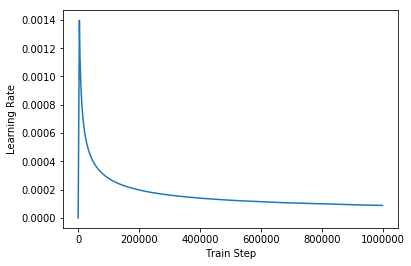

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(1000000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### optimizer and loss function

In [ ]:
# loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
#     from_logits=True, reduction='none')
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)

def loss_function(real, pred):
  loss = 0.0
  loss += loss_object(real, pred)
  # for key in keys:
  #   loss += loss_object(reals[key], preds[key])
  #   #loss += tf.reduce_mean(loss_object(reals[key], preds[key]))

  return loss

## Training and checkpointing

In [ ]:
transformer = TransformerClassifier(num_layers, d_model, num_heads, dff,
                          input_vocab_size, dcate_siz=dcate_siz, 
              rate=dropout_rate)

In [ ]:
def create_masks(inp):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
    
  return enc_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [ ]:
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 200

In [ ]:
keys=['dcate']

In [ ]:
@tf.function
def train_step(x):  
  enc_padding_mask = create_masks(x['title'])
  
  with tf.GradientTape() as tape:
    logits = transformer(x, True, enc_padding_mask)
    loss = loss_function(x['label'], logits)
    

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  return loss, logits

In [ ]:
@tf.function
def predict_step(x):
  enc_padding_mask = create_masks(x['title'])
  logits = transformer(x, False, enc_padding_mask)

  return logits

In [ ]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = os.path.join(tensor_board_path, current_time)
train_log_dir = os.path.join(train_log_dir, 'train')
test_log_dir = os.path.join(tensor_board_path, current_time)
test_log_dir = os.path.join(test_log_dir, 'test')
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

train_loss = tf.keras.metrics.Mean(name='train_loss')

train_acc_metric = {'dcate':tf.keras.metrics.SparseCategoricalAccuracy()}
valid_acc_metric = {'dcate':tf.keras.metrics.SparseCategoricalAccuracy()}

total_steps = 0
PRINT_STEPS = 500
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
  
  train_loss.reset_states()
  # inp -> portuguese, tar -> english
  for (batch, x) in enumerate(train_ds):
    total_steps += 1
    batch_loss, preds = train_step(x)
    total_loss += batch_loss
    
    train_loss(batch_loss)

    train_acc_metric['dcate'](x['label'], preds)

    if (batch+1) % PRINT_STEPS == 0:
      print('Epoch {} Batch {} total_step {} Loss {:.4f}'.format(epoch+1,
                                                     batch+1,
                                                     total_steps,
                                                     train_loss.result()
                                                  ))
      print('Seen so far: {} samples'.format(total_steps * BATCH_SIZE))

  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', train_acc_metric['dcate'].result(), step=epoch)
     
  train_acc = []
  train_acc.append('{},acc:{}'.format('dcate', float(train_acc_metric['dcate'].result())))
  train_acc_metric['dcate'].reset_states()
  
  print('Training loss {}, acc {} over epoch {}'.format(train_loss.result(), '\t'.join(train_acc), epoch+1))
  
  for (batch, x) in enumerate(valid_ds):
    valid_logits = predict_step(x)
    valid_acc_metric['dcate'](x['label'], valid_logits) 

  with test_summary_writer.as_default():
    tf.summary.scalar('accuracy', valid_acc_metric['dcate'].result(), step=epoch)

  valid_acc = []      
  valid_acc.append('{},acc:{}'.format('dcate', float(valid_acc_metric['dcate'].result())))
  valid_acc_metric['dcate'].reset_states()
    
  print('Validation acc over epoch {}: {}'.format(epoch+1, '\t'.join(valid_acc)))
  
  if (epoch + 1) % 3 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Training loss 7.88450813293457, acc dcate,acc:0.009239527396857738 over epoch 1
Validation acc over epoch 1: dcate,acc:0.03773773834109306
Time taken for 1 epoch: 729.0867390632629 secs

Training loss 6.104522705078125, acc dcate,acc:0.07023464143276215 over epoch 2
Validation acc over epoch 2: dcate,acc:0.1461561918258667
Time taken for 1 epoch: 642.6974456310272 secs

Training loss 4.733044147491455, acc dcate,acc:0.154713973402977 over epoch 3
Validation acc over epoch 3: dcate,acc:0.2323758453130722
Saving checkpoint for epoch 3 at gdrive/My Drive/data/prod_clf/checkpoints/title_image_v8192_small/ckpt-1
Time taken for 1 epoch: 642.4792604446411 secs

Training loss 4.080524444580078, acc dcate,acc:0.2145056277513504 over epoch 4
Validation acc over epoch 4: dcate,acc:0.2847059965133667
Time taken for 1 epoch: 635.1698656082153 secs

Training loss 3.717193841934204, acc dcate,acc:0.2559772729873657 over epoch 5
Validation acc over epoch 5: dcate,acc:0.3227759301662445
Time taken for 

In [ ]:
!ls -al

total 39908
drwxr-xr-x 1 root root     4096 Oct 10 08:20 .
drwxr-xr-x 1 root root     4096 Oct  9 23:52 ..
-rw-r--r-- 1 root root     2684 Oct  9 23:58 adc.json
drwxr-xr-x 1 root root     4096 Oct  9 23:58 .config
drwx------ 3 root root     4096 Oct 10 01:53 gdrive
-rwxr-xr-x 1 root root 26683198 Oct  8 19:55 ngrok
-rw-r--r-- 1 root root 13773305 Oct 10 08:20 ngrok-stable-linux-amd64.zip
drwxr-xr-x 1 root root     4096 Aug 27 16:17 sample_data
-rw-r--r-- 1 root root   299250 Oct  9 23:59 sp_10M.model
-rw-r--r-- 1 root root    65266 Oct  9 23:59 sp_10M.vocab
drwxr-xr-x 3 root root     4096 Oct 10 08:20 tmp


#### 타이틀 + 이미지: 20번 에포크시 VAL ACC: 0.40 대 (BATCH_SIZE = 512)

```
Epoch 1 Batch 100 Loss 3.2578
Seen so far: 51200 samples
Epoch 1 Batch 200 Loss 3.2198
Seen so far: 102400 samples
Epoch 1 Batch 300 Loss 3.2074
Seen so far: 153600 samples
Epoch 1 Batch 400 Loss 3.1938
Seen so far: 204800 samples
Epoch 1 Batch 500 Loss 3.1837
Seen so far: 256000 samples
Epoch 1 Batch 600 Loss 3.1762
Seen so far: 307200 samples
Epoch 1 Batch 700 Loss 3.1648
Seen so far: 358400 samples
Epoch 1 Batch 800 Loss 3.1218
Seen so far: 409600 samples
Epoch 1 Batch 900 Loss 3.0571
Seen so far: 460800 samples
Epoch 1 Batch 1000 Loss 3.0049
Seen so far: 512000 samples
Epoch 1 Batch 1100 Loss 2.9584
Seen so far: 563200 samples
Epoch 1 Batch 1200 Loss 2.9215
Seen so far: 614400 samples
Epoch 1 Batch 1300 Loss 2.8882
Seen so far: 665600 samples
Epoch 1 Batch 1400 Loss 2.8587
Seen so far: 716800 samples
Epoch 1 Batch 1500 Loss 2.8334
Seen so far: 768000 samples
Epoch 1 Batch 1600 Loss 2.8141
Seen so far: 819200 samples
Epoch 1 Batch 1700 Loss 2.8004
Seen so far: 870400 samples
Epoch 1 Batch 1800 Loss 2.7894
Seen so far: 921600 samples
Epoch 1 Batch 1900 Loss 2.7807
Seen so far: 972800 samples
Epoch 1 Batch 2000 Loss 2.7811
Seen so far: 1024000 samples
Epoch 1 Batch 2100 Loss 2.7874
Seen so far: 1075200 samples
Epoch 1 Batch 2200 Loss 2.7938
Seen so far: 1126400 samples
Epoch 1 Batch 2300 Loss 2.8017
Seen so far: 1177600 samples
Epoch 1 Batch 2400 Loss 2.8161
Seen so far: 1228800 samples
Epoch 1 Batch 2500 Loss 2.8301
Seen so far: 1280000 samples
Epoch 1 Batch 2600 Loss 2.8432
Seen so far: 1331200 samples
Epoch 1 Batch 2700 Loss 2.8544
Seen so far: 1382400 samples
Epoch 1 Batch 2800 Loss 2.8575
Seen so far: 1433600 samples
Epoch 1 Batch 2900 Loss 2.8583
Seen so far: 1484800 samples
Epoch 1 Batch 3000 Loss 2.8563
Seen so far: 1536000 samples
Epoch 1 Batch 3100 Loss 2.8459
Seen so far: 1587200 samples
Epoch 1 Batch 3200 Loss 2.8355
Seen so far: 1638400 samples
Epoch 1 Batch 3300 Loss 2.8253
Seen so far: 1689600 samples
Epoch 1 Batch 3400 Loss 2.8153
Seen so far: 1740800 samples
Epoch 1 Batch 3500 Loss 2.8058
Seen so far: 1792000 samples
Epoch 1 Batch 3600 Loss 2.7973
Seen so far: 1843200 samples
Epoch 1 Batch 3700 Loss 2.7891
Seen so far: 1894400 samples
Epoch 1 Batch 3800 Loss 2.7818
Seen so far: 1945600 samples
Epoch 1 Batch 3900 Loss 2.7776
Seen so far: 1996800 samples
Epoch 1 Batch 4000 Loss 2.7742
Seen so far: 2048000 samples
Epoch 1 Batch 4100 Loss 2.7701
Seen so far: 2099200 samples
Epoch 1 Batch 4200 Loss 2.7663
Seen so far: 2150400 samples
Training loss 2.764740228652954, acc dcate,acc:0.41291549801826477 over epoch 1
Validation acc over epoch 1: dcate,acc:0.4040367305278778
Time taken for 1 epoch: 1423.2469387054443 secs
```

#### 타이틀 (온리): 20번 에포크시 VAL ACC: 0.408 대 (BATCH_SIZE = 512)

```
Epoch 1 Batch 100 Loss 8.8723
Seen so far: 51200 samples
Epoch 1 Batch 200 Loss 8.6593
Seen so far: 102400 samples
Epoch 1 Batch 300 Loss 8.2883
Seen so far: 153600 samples
Epoch 1 Batch 400 Loss 8.0273
Seen so far: 204800 samples
Epoch 1 Batch 500 Loss 7.8373
Seen so far: 256000 samples
Epoch 1 Batch 600 Loss 7.6896
Seen so far: 307200 samples
Epoch 1 Batch 700 Loss 7.5618
Seen so far: 358400 samples
Epoch 1 Batch 800 Loss 7.4204
Seen so far: 409600 samples
Epoch 1 Batch 900 Loss 7.2465
Seen so far: 460800 samples
Epoch 1 Batch 1000 Loss 7.0694
Seen so far: 512000 samples
Epoch 1 Batch 1100 Loss 6.8956
Seen so far: 563200 samples
Epoch 1 Batch 1200 Loss 6.7307
Seen so far: 614400 samples
Epoch 1 Batch 1300 Loss 6.5768
Seen so far: 665600 samples
Epoch 1 Batch 1400 Loss 6.4311
Seen so far: 716800 samples
Epoch 1 Batch 1500 Loss 6.2970
Seen so far: 768000 samples
Epoch 1 Batch 1600 Loss 6.1824
Seen so far: 819200 samples
Epoch 1 Batch 1700 Loss 6.0809
Seen so far: 870400 samples
Epoch 1 Batch 1800 Loss 5.9828
Seen so far: 921600 samples
Epoch 1 Batch 1900 Loss 5.8891
Seen so far: 972800 samples
Epoch 1 Batch 2000 Loss 5.8209
Seen so far: 1024000 samples
Epoch 1 Batch 2100 Loss 5.7708
Seen so far: 1075200 samples
Epoch 1 Batch 2200 Loss 5.7220
Seen so far: 1126400 samples
Epoch 1 Batch 2300 Loss 5.6782
Seen so far: 1177600 samples
Epoch 1 Batch 2400 Loss 5.6458
Seen so far: 1228800 samples
Epoch 1 Batch 2500 Loss 5.6116
Seen so far: 1280000 samples
Epoch 1 Batch 2600 Loss 5.5765
Seen so far: 1331200 samples
Epoch 1 Batch 2700 Loss 5.5407
Seen so far: 1382400 samples
Epoch 1 Batch 2800 Loss 5.5012
Seen so far: 1433600 samples
Epoch 1 Batch 2900 Loss 5.4601
Seen so far: 1484800 samples
Epoch 1 Batch 3000 Loss 5.4176
Seen so far: 1536000 samples
Epoch 1 Batch 3100 Loss 5.3659
Seen so far: 1587200 samples
Epoch 1 Batch 3200 Loss 5.3148
Seen so far: 1638400 samples
Epoch 1 Batch 3300 Loss 5.2646
Seen so far: 1689600 samples
Epoch 1 Batch 3400 Loss 5.2159
Seen so far: 1740800 samples
Epoch 1 Batch 3500 Loss 5.1688
Seen so far: 1792000 samples
Epoch 1 Batch 3600 Loss 5.1244
Seen so far: 1843200 samples
Epoch 1 Batch 3700 Loss 5.0820
Seen so far: 1894400 samples
Epoch 1 Batch 3800 Loss 5.0432
Seen so far: 1945600 samples
Epoch 1 Batch 3900 Loss 5.0094
Seen so far: 1996800 samples
Epoch 1 Batch 4000 Loss 4.9751
Seen so far: 2048000 samples
Epoch 1 Batch 4100 Loss 4.9400
Seen so far: 2099200 samples
Epoch 1 Batch 4200 Loss 4.9053
Seen so far: 2150400 samples
Training loss 4.8917460441589355, acc dcate,acc:0.18037939071655273 over epoch 1
Validation acc over epoch 1: dcate,acc:0.18056800961494446
Time taken for 1 epoch: 1315.7310771942139 secs

...

Epoch 21 Batch 100 Loss 3.2581
Seen so far: 51200 samples
Epoch 21 Batch 200 Loss 3.2261
Seen so far: 102400 samples
Epoch 21 Batch 300 Loss 3.2063
Seen so far: 153600 samples
Epoch 21 Batch 400 Loss 3.1936
Seen so far: 204800 samples
Epoch 21 Batch 500 Loss 3.1797
Seen so far: 256000 samples
Epoch 21 Batch 600 Loss 3.1741
Seen so far: 307200 samples
Epoch 21 Batch 700 Loss 3.1669
Seen so far: 358400 samples
Epoch 21 Batch 800 Loss 3.1209
Seen so far: 409600 samples
Epoch 21 Batch 900 Loss 3.0563
Seen so far: 460800 samples
Epoch 21 Batch 1000 Loss 3.0044
Seen so far: 512000 samples
Epoch 21 Batch 1100 Loss 2.9595
Seen so far: 563200 samples
Epoch 21 Batch 1200 Loss 2.9212
Seen so far: 614400 samples
Epoch 21 Batch 1300 Loss 2.8881
Seen so far: 665600 samples
Epoch 21 Batch 1400 Loss 2.8581
Seen so far: 716800 samples
Epoch 21 Batch 1500 Loss 2.8321
Seen so far: 768000 samples
Epoch 21 Batch 1600 Loss 2.8130
Seen so far: 819200 samples
Epoch 21 Batch 1700 Loss 2.7992
Seen so far: 870400 samples
Epoch 21 Batch 1800 Loss 2.7876
Seen so far: 921600 samples
Epoch 21 Batch 1900 Loss 2.7797
Seen so far: 972800 samples
Epoch 21 Batch 2000 Loss 2.7797
Seen so far: 1024000 samples
Epoch 21 Batch 2100 Loss 2.7857
Seen so far: 1075200 samples
Epoch 21 Batch 2200 Loss 2.7918
Seen so far: 1126400 samples
Epoch 21 Batch 2300 Loss 2.7991
Seen so far: 1177600 samples
Epoch 21 Batch 2400 Loss 2.8130
Seen so far: 1228800 samples
Epoch 21 Batch 2500 Loss 2.8265
Seen so far: 1280000 samples
Epoch 21 Batch 2600 Loss 2.8403
Seen so far: 1331200 samples
Epoch 21 Batch 2700 Loss 2.8512
Seen so far: 1382400 samples
Epoch 21 Batch 2800 Loss 2.8544
Seen so far: 1433600 samples
Epoch 21 Batch 2900 Loss 2.8542
Seen so far: 1484800 samples
Epoch 21 Batch 3000 Loss 2.8528
Seen so far: 1536000 samples
Epoch 21 Batch 3100 Loss 2.8427
Seen so far: 1587200 samples
Epoch 21 Batch 3200 Loss 2.8316
Seen so far: 1638400 samples
Epoch 21 Batch 3300 Loss 2.8211
Seen so far: 1689600 samples
Epoch 21 Batch 3400 Loss 2.8115
Seen so far: 1740800 samples
Epoch 21 Batch 3500 Loss 2.8020
Seen so far: 1792000 samples
Epoch 21 Batch 3600 Loss 2.7932
Seen so far: 1843200 samples
Epoch 21 Batch 3700 Loss 2.7848
Seen so far: 1894400 samples
Epoch 21 Batch 3800 Loss 2.7774
Seen so far: 1945600 samples
Epoch 21 Batch 3900 Loss 2.7725
Seen so far: 1996800 samples
Epoch 21 Batch 4000 Loss 2.7689
Seen so far: 2048000 samples
Epoch 21 Batch 4100 Loss 2.7647
Seen so far: 2099200 samples
Epoch 21 Batch 4200 Loss 2.7609
Seen so far: 2150400 samples
Training loss 2.7592458724975586, acc dcate,acc:0.4174620509147644 over epoch 21
Validation acc over epoch 21: dcate,acc:0.40857332944869995
Saving checkpoint for epoch 21 at gdrive/My Drive/data/checkpoints/train_prod_clf_title_only/ckpt-7
Time taken for 1 epoch: 1236.48423910141 secs
 
```

## 참고: 배송 2.0 딜의 타이틀로만 구성했을 때 결과

#### 학습 로그, BATCH_SIZE=1,024





```
Epoch 1 Batch 100 Loss 23.2969
Seen so far: 102400 samples
Epoch 1 Batch 200 Loss 21.7064
Seen so far: 204800 samples
Epoch 1 Batch 300 Loss 20.1441
Seen so far: 307200 samples
Epoch 1 Batch 400 Loss 18.6555
Seen so far: 409600 samples
Epoch 1 Batch 500 Loss 17.3532
Seen so far: 512000 samples
Epoch 1 Batch 600 Loss 16.2529
Seen so far: 614400 samples
Epoch 1 Batch 700 Loss 15.3040
Seen so far: 716800 samples
Epoch 1 Batch 800 Loss 14.4827
Seen so far: 819200 samples
Training loss 13.919532775878906, acc dcate,acc:0.1611873060464859	scate,acc:0.21777121722698212	mcate,acc:0.36421775817871094	lcate,acc:0.5731943845748901 over epoch 1
Validation acc over epoch 1: dcate,acc:0.350193589925766	scate,acc:0.45061057806015015	mcate,acc:0.6368991732597351	lcate,acc:0.7929887771606445
Time taken for 1 epoch: 439.31024861335754 secs

Epoch 2 Batch 100 Loss 7.5944
Seen so far: 102400 samples
Epoch 2 Batch 200 Loss 7.3805
Seen so far: 204800 samples
Epoch 2 Batch 300 Loss 7.1792
Seen so far: 307200 samples
Epoch 2 Batch 400 Loss 7.0096
Seen so far: 409600 samples
Epoch 2 Batch 500 Loss 6.8594
Seen so far: 512000 samples
Epoch 2 Batch 600 Loss 6.7293
Seen so far: 614400 samples
Epoch 2 Batch 700 Loss 6.6036
Seen so far: 716800 samples
Epoch 2 Batch 800 Loss 6.4905
Seen so far: 819200 samples
Training loss 6.409360885620117, acc dcate,acc:0.4262094795703888	scate,acc:0.5222941040992737	mcate,acc:0.6740705966949463	lcate,acc:0.7965869307518005 over epoch 2
Validation acc over epoch 2: dcate,acc:0.4974597990512848	scate,acc:0.5961183905601501	mcate,acc:0.7234352231025696	lcate,acc:0.8268563151359558
Time taken for 1 epoch: 333.6743543148041 secs

Epoch 3 Batch 100 Loss 5.4100
Seen so far: 102400 samples
Epoch 3 Batch 200 Loss 5.3538
Seen so far: 204800 samples
Epoch 3 Batch 300 Loss 5.2882
Seen so far: 307200 samples
Epoch 3 Batch 400 Loss 5.2371
Seen so far: 409600 samples
Epoch 3 Batch 500 Loss 5.1870
Seen so far: 512000 samples
Epoch 3 Batch 600 Loss 5.1496
Seen so far: 614400 samples
Epoch 3 Batch 700 Loss 5.1072
Seen so far: 716800 samples
Epoch 3 Batch 800 Loss 5.0690
Seen so far: 819200 samples
Training loss 5.0410661697387695, acc dcate,acc:0.5126997828483582	scate,acc:0.6068646311759949	mcate,acc:0.7247795462608337	lcate,acc:0.8239762783050537 over epoch 3
Validation acc over epoch 3: dcate,acc:0.5479518175125122	scate,acc:0.637955904006958	mcate,acc:0.748144268989563	lcate,acc:0.8408632874488831
Saving checkpoint for epoch 3 at gdrive/My Drive/data/checkpoints/train_transformer_classifier/ckpt-1
Time taken for 1 epoch: 335.8052759170532 secs

Epoch 4 Batch 100 Loss 4.6416
Seen so far: 102400 samples
Epoch 4 Batch 200 Loss 4.6158
Seen so far: 204800 samples
Epoch 4 Batch 300 Loss 4.5857
Seen so far: 307200 samples
Epoch 4 Batch 400 Loss 4.5627
Seen so far: 409600 samples
Epoch 4 Batch 500 Loss 4.5416
Seen so far: 512000 samples
Epoch 4 Batch 600 Loss 4.5276
Seen so far: 614400 samples
Epoch 4 Batch 700 Loss 4.5071
Seen so far: 716800 samples
Epoch 4 Batch 800 Loss 4.4895
Seen so far: 819200 samples
Training loss 4.474783897399902, acc dcate,acc:0.5520581007003784	scate,acc:0.6408641338348389	mcate,acc:0.7497997879981995	lcate,acc:0.8410171866416931 over epoch 4
Validation acc over epoch 4: dcate,acc:0.5716699361801147	scate,acc:0.660651683807373	mcate,acc:0.7638351321220398	lcate,acc:0.8523700833320618
Time taken for 1 epoch: 325.24789571762085 secs

Epoch 5 Batch 100 Loss 4.2482
Seen so far: 102400 samples
Epoch 5 Batch 200 Loss 4.2358
Seen so far: 204800 samples
Epoch 5 Batch 300 Loss 4.2155
Seen so far: 307200 samples
Epoch 5 Batch 400 Loss 4.2015
Seen so far: 409600 samples
Epoch 5 Batch 500 Loss 4.1909
Seen so far: 512000 samples
Epoch 5 Batch 600 Loss 4.1841
Seen so far: 614400 samples
Epoch 5 Batch 700 Loss 4.1690
Seen so far: 716800 samples
Epoch 5 Batch 800 Loss 4.1556
Seen so far: 819200 samples
Training loss 4.143682956695557, acc dcate,acc:0.5748549699783325	scate,acc:0.6619903445243835	mcate,acc:0.7672155499458313	lcate,acc:0.8533721566200256 over epoch 5
Validation acc over epoch 5: dcate,acc:0.5871317386627197	scate,acc:0.6730835437774658	mcate,acc:0.7732484936714172	lcate,acc:0.8590399622917175
Time taken for 1 epoch: 335.0390079021454 secs

Epoch 6 Batch 100 Loss 3.9479
Seen so far: 102400 samples
Epoch 6 Batch 200 Loss 3.9304
Seen so far: 204800 samples
Epoch 6 Batch 300 Loss 3.9068
Seen so far: 307200 samples
Epoch 6 Batch 400 Loss 3.8910
Seen so far: 409600 samples
Epoch 6 Batch 500 Loss 3.8747
Seen so far: 512000 samples
Epoch 6 Batch 600 Loss 3.8649
Seen so far: 614400 samples
Epoch 6 Batch 700 Loss 3.8493
Seen so far: 716800 samples
Epoch 6 Batch 800 Loss 3.8366
Seen so far: 819200 samples
Training loss 3.825269937515259, acc dcate,acc:0.5975995063781738	scate,acc:0.6828941106796265	mcate,acc:0.7842174768447876	lcate,acc:0.8655735850334167 over epoch 6
Validation acc over epoch 6: dcate,acc:0.604065477848053	scate,acc:0.6875945329666138	mcate,acc:0.7855543494224548	lcate,acc:0.8666032552719116
Saving checkpoint for epoch 6 at gdrive/My Drive/data/checkpoints/train_transformer_classifier/ckpt-2
Time taken for 1 epoch: 325.6901412010193 secs

Epoch 7 Batch 100 Loss 3.6518
Seen so far: 102400 samples
Epoch 7 Batch 200 Loss 3.6455
Seen so far: 204800 samples
Epoch 7 Batch 300 Loss 3.6294
Seen so far: 307200 samples
Epoch 7 Batch 400 Loss 3.6197
Seen so far: 409600 samples
Epoch 7 Batch 500 Loss 3.6075
Seen so far: 512000 samples
Epoch 7 Batch 600 Loss 3.6010
Seen so far: 614400 samples
Epoch 7 Batch 700 Loss 3.5930
Seen so far: 716800 samples
Epoch 7 Batch 800 Loss 3.5844
Seen so far: 819200 samples
Training loss 3.5761101245880127, acc dcate,acc:0.614652693271637	scate,acc:0.6986381411552429	mcate,acc:0.7984544038772583	lcate,acc:0.8764270544052124 over epoch 7
Validation acc over epoch 7: dcate,acc:0.6118665337562561	scate,acc:0.6939235329627991	mcate,acc:0.7920494675636292	lcate,acc:0.870543897151947
Time taken for 1 epoch: 335.8001775741577 secs

Epoch 8 Batch 100 Loss 3.4407
Seen so far: 102400 samples
Epoch 8 Batch 200 Loss 3.4454
Seen so far: 204800 samples
Epoch 8 Batch 300 Loss 3.4270
Seen so far: 307200 samples
Epoch 8 Batch 400 Loss 3.4190
Seen so far: 409600 samples
Epoch 8 Batch 500 Loss 3.4116
Seen so far: 512000 samples
Epoch 8 Batch 600 Loss 3.4087
Seen so far: 614400 samples
Epoch 8 Batch 700 Loss 3.4013
Seen so far: 716800 samples
Epoch 8 Batch 800 Loss 3.3959
Seen so far: 819200 samples
Training loss 3.390206813812256, acc dcate,acc:0.6279208064079285	scate,acc:0.7105492949485779	mcate,acc:0.808826208114624	lcate,acc:0.8832996487617493 over epoch 8
Validation acc over epoch 8: dcate,acc:0.6196074485778809	scate,acc:0.699837327003479	mcate,acc:0.7988768219947815	lcate,acc:0.874710738658905
Time taken for 1 epoch: 326.1968834400177 secs

Epoch 9 Batch 100 Loss 3.2849
Seen so far: 102400 samples
Epoch 9 Batch 200 Loss 3.2870
Seen so far: 204800 samples
Epoch 9 Batch 300 Loss 3.2736
Seen so far: 307200 samples
Epoch 9 Batch 400 Loss 3.2670
Seen so far: 409600 samples
Epoch 9 Batch 500 Loss 3.2617
Seen so far: 512000 samples
Epoch 9 Batch 600 Loss 3.2596
Seen so far: 614400 samples
Epoch 9 Batch 700 Loss 3.2543
Seen so far: 716800 samples
Epoch 9 Batch 800 Loss 3.2512
Seen so far: 819200 samples
Training loss 3.245605707168579, acc dcate,acc:0.6382614374160767	scate,acc:0.7202949523925781	mcate,acc:0.8175529837608337	lcate,acc:0.8893436789512634 over epoch 9
Validation acc over epoch 9: dcate,acc:0.6257045269012451	scate,acc:0.7059916853904724	mcate,acc:0.8036679625511169	lcate,acc:0.877806544303894
Saving checkpoint for epoch 9 at gdrive/My Drive/data/checkpoints/train_transformer_classifier/ckpt-3
Time taken for 1 epoch: 336.3138952255249 secs

Epoch 10 Batch 100 Loss 3.1707
Seen so far: 102400 samples
Epoch 10 Batch 200 Loss 3.1629
Seen so far: 204800 samples
Epoch 10 Batch 300 Loss 3.1538
Seen so far: 307200 samples
Epoch 10 Batch 400 Loss 3.1482
Seen so far: 409600 samples
Epoch 10 Batch 500 Loss 3.1449
Seen so far: 512000 samples
Epoch 10 Batch 600 Loss 3.1440
Seen so far: 614400 samples
Epoch 10 Batch 700 Loss 3.1399
Seen so far: 716800 samples
Epoch 10 Batch 800 Loss 3.1388
Seen so far: 819200 samples
Training loss 3.1341264247894287, acc dcate,acc:0.645902693271637	scate,acc:0.7276803255081177	mcate,acc:0.823177695274353	lcate,acc:0.8935224413871765 over epoch 10
Validation acc over epoch 10: dcate,acc:0.6301634907722473	scate,acc:0.709465503692627	mcate,acc:0.806047797203064	lcate,acc:0.8791812062263489
Time taken for 1 epoch: 325.63170981407166 secs

Epoch 11 Batch 100 Loss 3.0665
Seen so far: 102400 samples
Epoch 11 Batch 200 Loss 3.0603
Seen so far: 204800 samples
Epoch 11 Batch 300 Loss 3.0508
Seen so far: 307200 samples
Epoch 11 Batch 400 Loss 3.0450
Seen so far: 409600 samples
Epoch 11 Batch 500 Loss 3.0431
Seen so far: 512000 samples
Epoch 11 Batch 600 Loss 3.0427
Seen so far: 614400 samples
Epoch 11 Batch 700 Loss 3.0393
Seen so far: 716800 samples
Epoch 11 Batch 800 Loss 3.0380
Seen so far: 819200 samples
Training loss 3.033891439437866, acc dcate,acc:0.6532235741615295	scate,acc:0.7346063256263733	mcate,acc:0.8291382789611816	lcate,acc:0.8975031971931458 over epoch 11
Validation acc over epoch 11: dcate,acc:0.6329814791679382	scate,acc:0.7128562331199646	mcate,acc:0.8071933388710022	lcate,acc:0.8806130886077881
Time taken for 1 epoch: 325.49516248703003 secs

Epoch 12 Batch 100 Loss 2.9791
Seen so far: 102400 samples
Epoch 12 Batch 200 Loss 2.9742
Seen so far: 204800 samples
Epoch 12 Batch 300 Loss 2.9663
Seen so far: 307200 samples
Epoch 12 Batch 400 Loss 2.9605
Seen so far: 409600 samples
Epoch 12 Batch 500 Loss 2.9595
Seen so far: 512000 samples
Epoch 12 Batch 600 Loss 2.9605
Seen so far: 614400 samples
Epoch 12 Batch 700 Loss 2.9565
Seen so far: 716800 samples
Epoch 12 Batch 800 Loss 2.9562
Seen so far: 819200 samples
Training loss 2.953066110610962, acc dcate,acc:0.6590818166732788	scate,acc:0.7402032613754272	mcate,acc:0.8338998556137085	lcate,acc:0.9009333848953247 over epoch 12
Validation acc over epoch 12: dcate,acc:0.636483907699585	scate,acc:0.7151387333869934	mcate,acc:0.8100915551185608	lcate,acc:0.8829872012138367
Saving checkpoint for epoch 12 at gdrive/My Drive/data/checkpoints/train_transformer_classifier/ckpt-4
Time taken for 1 epoch: 326.1110873222351 secs

Epoch 13 Batch 100 Loss 2.8943
Seen so far: 102400 samples
Epoch 13 Batch 200 Loss 2.8936
Seen so far: 204800 samples
Epoch 13 Batch 300 Loss 2.8888
Seen so far: 307200 samples
Epoch 13 Batch 400 Loss 2.8839
Seen so far: 409600 samples
Epoch 13 Batch 500 Loss 2.8815
Seen so far: 512000 samples
Epoch 13 Batch 600 Loss 2.8828
Seen so far: 614400 samples
Epoch 13 Batch 700 Loss 2.8802
Seen so far: 716800 samples
Epoch 13 Batch 800 Loss 2.8799
Seen so far: 819200 samples
Training loss 2.877784490585327, acc dcate,acc:0.6643672585487366	scate,acc:0.7454441785812378	mcate,acc:0.8382031917572021	lcate,acc:0.904041051864624 over epoch 13
Validation acc over epoch 13: dcate,acc:0.6379874348640442	scate,acc:0.71627277135849	mcate,acc:0.8112657070159912	lcate,acc:0.8835828900337219
Time taken for 1 epoch: 325.565217256546 secs

Epoch 14 Batch 100 Loss 2.8366
Seen so far: 102400 samples
Epoch 14 Batch 200 Loss 2.8317
Seen so far: 204800 samples
Epoch 14 Batch 300 Loss 2.8234
Seen so far: 307200 samples
Epoch 14 Batch 400 Loss 2.8199
Seen so far: 409600 samples
Epoch 14 Batch 500 Loss 2.8181
Seen so far: 512000 samples
Epoch 14 Batch 600 Loss 2.8195
Seen so far: 614400 samples
Epoch 14 Batch 700 Loss 2.8179
Seen so far: 716800 samples
Epoch 14 Batch 800 Loss 2.8202
Seen so far: 819200 samples
Training loss 2.8178536891937256, acc dcate,acc:0.6687517762184143	scate,acc:0.7494861483573914	mcate,acc:0.8409715890884399	lcate,acc:0.9060553312301636 over epoch 14
Validation acc over epoch 14: dcate,acc:0.6415843963623047	scate,acc:0.7201848030090332	mcate,acc:0.8130154609680176	lcate,acc:0.8845279216766357
Time taken for 1 epoch: 325.72965908050537 secs

Epoch 15 Batch 100 Loss 2.7819
Seen so far: 102400 samples
Epoch 15 Batch 200 Loss 2.7718
Seen so far: 204800 samples
Epoch 15 Batch 300 Loss 2.7635
Seen so far: 307200 samples
Epoch 15 Batch 400 Loss 2.7613
Seen so far: 409600 samples
Epoch 15 Batch 500 Loss 2.7608
Seen so far: 512000 samples
Epoch 15 Batch 600 Loss 2.7614
Seen so far: 614400 samples
Epoch 15 Batch 700 Loss 2.7589
Seen so far: 716800 samples
Epoch 15 Batch 800 Loss 2.7592
Seen so far: 819200 samples
Training loss 2.7584099769592285, acc dcate,acc:0.673072874546051	scate,acc:0.7530487179756165	mcate,acc:0.844663143157959	lcate,acc:0.9085401296615601 over epoch 15
Validation acc over epoch 15: dcate,acc:0.642357587814331	scate,acc:0.7201017141342163	mcate,acc:0.8137428760528564	lcate,acc:0.8847570419311523
Saving checkpoint for epoch 15 at gdrive/My Drive/data/checkpoints/train_transformer_classifier/ckpt-5
Time taken for 1 epoch: 325.56688928604126 secs

Epoch 16 Batch 100 Loss 2.7261
Seen so far: 102400 samples
Epoch 16 Batch 200 Loss 2.7187
Seen so far: 204800 samples
Epoch 16 Batch 300 Loss 2.7128
Seen so far: 307200 samples
Epoch 16 Batch 400 Loss 2.7115
Seen so far: 409600 samples
Epoch 16 Batch 500 Loss 2.7109
Seen so far: 512000 samples
Epoch 16 Batch 600 Loss 2.7147
Seen so far: 614400 samples
Epoch 16 Batch 700 Loss 2.7115
Seen so far: 716800 samples
Epoch 16 Batch 800 Loss 2.7121
Seen so far: 819200 samples
Training loss 2.7108566761016846, acc dcate,acc:0.6766054034233093	scate,acc:0.756614625453949	mcate,acc:0.8476240038871765	lcate,acc:0.9104965925216675 over epoch 16
Validation acc over epoch 16: dcate,acc:0.6432310938835144	scate,acc:0.7211269736289978	mcate,acc:0.814644992351532	lcate,acc:0.8848143219947815
Time taken for 1 epoch: 334.76745343208313 secs

Epoch 17 Batch 100 Loss 2.6695
Seen so far: 102400 samples
Epoch 17 Batch 200 Loss 2.6664
Seen so far: 204800 samples
Epoch 17 Batch 300 Loss 2.6629
Seen so far: 307200 samples
Epoch 17 Batch 400 Loss 2.6598
Seen so far: 409600 samples
Epoch 17 Batch 500 Loss 2.6608
Seen so far: 512000 samples
Epoch 17 Batch 600 Loss 2.6628
Seen so far: 614400 samples
Epoch 17 Batch 700 Loss 2.6598
Seen so far: 716800 samples
Epoch 17 Batch 800 Loss 2.6617
Seen so far: 819200 samples
Training loss 2.6603641510009766, acc dcate,acc:0.6806095838546753	scate,acc:0.7602828145027161	mcate,acc:0.8503623604774475	lcate,acc:0.9124675393104553 over epoch 17
Validation acc over epoch 17: dcate,acc:0.645218551158905	scate,acc:0.7229512333869934	mcate,acc:0.8160597085952759	lcate,acc:0.8860830068588257
Time taken for 1 epoch: 325.09432458877563 secs

Epoch 18 Batch 100 Loss 2.6304
Seen so far: 102400 samples
Epoch 18 Batch 200 Loss 2.6282
Seen so far: 204800 samples
Epoch 18 Batch 300 Loss 2.6199
Seen so far: 307200 samples
Epoch 18 Batch 400 Loss 2.6172
Seen so far: 409600 samples
Epoch 18 Batch 500 Loss 2.6178
Seen so far: 512000 samples
Epoch 18 Batch 600 Loss 2.6210
Seen so far: 614400 samples
Epoch 18 Batch 700 Loss 2.6197
Seen so far: 716800 samples
Epoch 18 Batch 800 Loss 2.6210
Seen so far: 819200 samples
Training loss 2.6198177337646484, acc dcate,acc:0.6833835244178772	scate,acc:0.7631001472473145	mcate,acc:0.8529072403907776	lcate,acc:0.9141648411750793 over epoch 18
Validation acc over epoch 18: dcate,acc:0.6455908417701721	scate,acc:0.7228595614433289	mcate,acc:0.8158735632896423	lcate,acc:0.8866385817527771
Saving checkpoint for epoch 18 at gdrive/My Drive/data/checkpoints/train_transformer_classifier/ckpt-6
Time taken for 1 epoch: 326.76388335227966 secs

Epoch 19 Batch 100 Loss 2.6016
Seen so far: 102400 samples
Epoch 19 Batch 200 Loss 2.5959
Seen so far: 204800 samples
Epoch 19 Batch 300 Loss 2.5860
Seen so far: 307200 samples
Epoch 19 Batch 400 Loss 2.5807
Seen so far: 409600 samples
Epoch 19 Batch 500 Loss 2.5789
Seen so far: 512000 samples
Epoch 19 Batch 600 Loss 2.5800
Seen so far: 614400 samples
Epoch 19 Batch 700 Loss 2.5782
Seen so far: 716800 samples
Epoch 19 Batch 800 Loss 2.5790
Seen so far: 819200 samples
Training loss 2.578908681869507, acc dcate,acc:0.686680257320404	scate,acc:0.7661811113357544	mcate,acc:0.8554387092590332	lcate,acc:0.9157086610794067 over epoch 19
Validation acc over epoch 19: dcate,acc:0.6471402049064636	scate,acc:0.7249501943588257	mcate,acc:0.8169732689857483	lcate,acc:0.8857994675636292
Time taken for 1 epoch: 324.250257730484 secs

Epoch 20 Batch 100 Loss 2.5586
Seen so far: 102400 samples
Epoch 20 Batch 200 Loss 2.5536
Seen so far: 204800 samples
Epoch 20 Batch 300 Loss 2.5477
Seen so far: 307200 samples
Epoch 20 Batch 400 Loss 2.5451
Seen so far: 409600 samples
Epoch 20 Batch 500 Loss 2.5452
Seen so far: 512000 samples
Epoch 20 Batch 600 Loss 2.5461
Seen so far: 614400 samples
Epoch 20 Batch 700 Loss 2.5452
Seen so far: 716800 samples
Epoch 20 Batch 800 Loss 2.5463
Seen so far: 819200 samples
Training loss 2.5459542274475098, acc dcate,acc:0.6887779831886292	scate,acc:0.7682754993438721	mcate,acc:0.8569892048835754	lcate,acc:0.9172168374061584 over epoch 20
Validation acc over epoch 20: dcate,acc:0.6497806310653687	scate,acc:0.726370632648468	mcate,acc:0.8177894949913025	lcate,acc:0.886787474155426
Time taken for 1 epoch: 325.4898090362549 secs

```



#### 학습로그, BATCH_SIZE=2,048



```
Epoch 1 Batch 100 Loss 20.7126
Seen so far: 204800 samples
Epoch 1 Batch 200 Loss 19.1006
Seen so far: 409600 samples
Epoch 1 Batch 300 Loss 17.5073
Seen so far: 614400 samples
Epoch 1 Batch 400 Loss 16.1323
Seen so far: 819200 samples
Training loss 15.654592514038086, acc dcate,acc:0.07290183752775192	scate,acc:0.158364400267601	mcate,acc:0.29980024695396423	lcate,acc:0.5377344489097595 over epoch 1
Validation acc over epoch 1: dcate,acc:0.21368910372257233	scate,acc:0.3176470696926117	mcate,acc:0.5324735641479492	lcate,acc:0.7498018145561218
Time taken for 1 epoch: 359.1522009372711 secs

Epoch 2 Batch 100 Loss 9.7618
Seen so far: 204800 samples
Epoch 2 Batch 200 Loss 9.1928
Seen so far: 409600 samples
Epoch 2 Batch 300 Loss 8.7245
Seen so far: 614400 samples
Epoch 2 Batch 400 Loss 8.3452
Seen so far: 819200 samples
Training loss 8.21285343170166, acc dcate,acc:0.3184172213077545	scate,acc:0.4169376790523529	mcate,acc:0.6051706671714783	lcate,acc:0.7719826698303223 over epoch 2
Validation acc over epoch 2: dcate,acc:0.4078182578086853	scate,acc:0.513801097869873	mcate,acc:0.6864631175994873	lcate,acc:0.8109892010688782
Time taken for 1 epoch: 338.88829922676086 secs

Epoch 3 Batch 100 Loss 6.5688
Seen so far: 204800 samples
Epoch 3 Batch 200 Loss 6.3846
Seen so far: 409600 samples
Epoch 3 Batch 300 Loss 6.2236
Seen so far: 614400 samples
Epoch 3 Batch 400 Loss 6.0866
Seen so far: 819200 samples
Training loss 6.036114692687988, acc dcate,acc:0.4433082044124603	scate,acc:0.5432434678077698	mcate,acc:0.6916353702545166	lcate,acc:0.8083312511444092 over epoch 3
Validation acc over epoch 3: dcate,acc:0.4938131868839264	scate,acc:0.5952177047729492	mcate,acc:0.7269847393035889	lcate,acc:0.8270421624183655
Saving checkpoint for epoch 3 at gdrive/My Drive/data/checkpoints/train_transformer_classifier/ckpt-1
Time taken for 1 epoch: 329.042849779129 secs

Epoch 4 Batch 100 Loss 5.3765
Seen so far: 204800 samples
Epoch 4 Batch 200 Loss 5.2882
Seen so far: 409600 samples
Epoch 4 Batch 300 Loss 5.2074
Seen so far: 614400 samples
Epoch 4 Batch 400 Loss 5.1386
Seen so far: 819200 samples
Training loss 5.111425876617432, acc dcate,acc:0.5046759247779846	scate,acc:0.6007372140884399	mcate,acc:0.7245070338249207	lcate,acc:0.8248827457427979 over epoch 4
Validation acc over epoch 4: dcate,acc:0.5347713828086853	scate,acc:0.6312241554260254	mcate,acc:0.7467802166938782	lcate,acc:0.8399844765663147
Time taken for 1 epoch: 328.50467562675476 secs

Epoch 5 Batch 100 Loss 4.7599
Seen so far: 204800 samples
Epoch 5 Batch 200 Loss 4.7062
Seen so far: 409600 samples
Epoch 5 Batch 300 Loss 4.6538
Seen so far: 614400 samples
Epoch 5 Batch 400 Loss 4.6114
Seen so far: 819200 samples
Training loss 4.593683242797852, acc dcate,acc:0.5402659773826599	scate,acc:0.6321774125099182	mcate,acc:0.7447924017906189	lcate,acc:0.8380663394927979 over epoch 5
Validation acc over epoch 5: dcate,acc:0.5618681311607361	scate,acc:0.6526281237602234	mcate,acc:0.7593032121658325	lcate,acc:0.8461540937423706
Time taken for 1 epoch: 328.8026864528656 secs

Epoch 6 Batch 100 Loss 4.3561
Seen so far: 204800 samples
Epoch 6 Batch 200 Loss 4.3189
Seen so far: 409600 samples
Epoch 6 Batch 300 Loss 4.2840
Seen so far: 614400 samples
Epoch 6 Batch 400 Loss 4.2569
Seen so far: 819200 samples
Training loss 4.2443742752075195, acc dcate,acc:0.5655531287193298	scate,acc:0.6538052558898926	mcate,acc:0.7604385614395142	lcate,acc:0.8485127091407776 over epoch 6
Validation acc over epoch 6: dcate,acc:0.5805060863494873	scate,acc:0.6682358980178833	mcate,acc:0.7716050148010254	lcate,acc:0.8548626899719238
Saving checkpoint for epoch 6 at gdrive/My Drive/data/checkpoints/train_transformer_classifier/ckpt-2
Time taken for 1 epoch: 328.5753698348999 secs

Epoch 7 Batch 100 Loss 4.0764
Seen so far: 204800 samples
Epoch 7 Batch 200 Loss 4.0440
Seen so far: 409600 samples
Epoch 7 Batch 300 Loss 4.0168
Seen so far: 614400 samples
Epoch 7 Batch 400 Loss 3.9969
Seen so far: 819200 samples
Training loss 3.9883029460906982, acc dcate,acc:0.5843369364738464	scate,acc:0.6698818206787109	mcate,acc:0.7726767063140869	lcate,acc:0.857229471206665 over epoch 7
Validation acc over epoch 7: dcate,acc:0.5922161936759949	scate,acc:0.678630530834198	mcate,acc:0.7791905999183655	lcate,acc:0.8594152331352234
Time taken for 1 epoch: 328.5116934776306 secs

Epoch 8 Batch 100 Loss 3.8580
Seen so far: 204800 samples
Epoch 8 Batch 200 Loss 3.8330
Seen so far: 409600 samples
Epoch 8 Batch 300 Loss 3.8117
Seen so far: 614400 samples
Epoch 8 Batch 400 Loss 3.7988
Seen so far: 819200 samples
Training loss 3.792379856109619, acc dcate,acc:0.5982691049575806	scate,acc:0.6822735071182251	mcate,acc:0.7833132147789001	lcate,acc:0.8647783398628235 over epoch 8
Validation acc over epoch 8: dcate,acc:0.6023581027984619	scate,acc:0.6859001517295837	mcate,acc:0.7848747968673706	lcate,acc:0.8628360629081726
Time taken for 1 epoch: 329.2802770137787 secs

Epoch 9 Batch 100 Loss 3.6920
Seen so far: 204800 samples
Epoch 9 Batch 200 Loss 3.6729
Seen so far: 409600 samples
Epoch 9 Batch 300 Loss 3.6564
Seen so far: 614400 samples
Epoch 9 Batch 400 Loss 3.6465
Seen so far: 819200 samples
Training loss 3.6407313346862793, acc dcate,acc:0.6086587309837341	scate,acc:0.6918110847473145	mcate,acc:0.7913737893104553	lcate,acc:0.8709580302238464 over epoch 9
Validation acc over epoch 9: dcate,acc:0.6070599555969238	scate,acc:0.6897633075714111	mcate,acc:0.7873793840408325	lcate,acc:0.862580418586731
Saving checkpoint for epoch 9 at gdrive/My Drive/data/checkpoints/train_transformer_classifier/ckpt-3
Time taken for 1 epoch: 328.94570541381836 secs

Epoch 10 Batch 100 Loss 3.5643
Seen so far: 204800 samples
Epoch 10 Batch 200 Loss 3.5365
Seen so far: 409600 samples
Epoch 10 Batch 300 Loss 3.5111
Seen so far: 614400 samples
Epoch 10 Batch 400 Loss 3.4958
Seen so far: 819200 samples
Training loss 3.487203359603882, acc dcate,acc:0.6195443868637085	scate,acc:0.7015722990036011	mcate,acc:0.7999181151390076	lcate,acc:0.8767951726913452 over epoch 10
Validation acc over epoch 10: dcate,acc:0.6154842376708984	scate,acc:0.6970645785331726	mcate,acc:0.7936667203903198	lcate,acc:0.8693617582321167
Time taken for 1 epoch: 328.8429343700409 secs

Epoch 11 Batch 100 Loss 3.3983
Seen so far: 204800 samples
Epoch 11 Batch 200 Loss 3.3699
Seen so far: 409600 samples
Epoch 11 Batch 300 Loss 3.3499
Seen so far: 614400 samples
Epoch 11 Batch 400 Loss 3.3368
Seen so far: 819200 samples
Training loss 3.330162286758423, acc dcate,acc:0.630510151386261	scate,acc:0.7115025520324707	mcate,acc:0.8090275526046753	lcate,acc:0.8832206726074219 over epoch 11
Validation acc over epoch 11: dcate,acc:0.6214786171913147	scate,acc:0.7011575102806091	mcate,acc:0.7979118824005127	lcate,acc:0.8723489046096802
Time taken for 1 epoch: 329.15449500083923 secs

Epoch 12 Batch 100 Loss 3.2527
Seen so far: 204800 samples
Epoch 12 Batch 200 Loss 3.2288
Seen so far: 409600 samples
Epoch 12 Batch 300 Loss 3.2143
Seen so far: 614400 samples
Epoch 12 Batch 400 Loss 3.2044
Seen so far: 819200 samples
Training loss 3.1991186141967773, acc dcate,acc:0.6399198174476624	scate,acc:0.7206208109855652	mcate,acc:0.8166153430938721	lcate,acc:0.8892914056777954 over epoch 12
Validation acc over epoch 12: dcate,acc:0.6285357475280762	scate,acc:0.7071346640586853	mcate,acc:0.8024758696556091	lcate,acc:0.8766084313392639
Saving checkpoint for epoch 12 at gdrive/My Drive/data/checkpoints/train_transformer_classifier/ckpt-4
Time taken for 1 epoch: 329.55933117866516 secs

Epoch 13 Batch 100 Loss 3.1382
Seen so far: 204800 samples
Epoch 13 Batch 200 Loss 3.1132
Seen so far: 409600 samples
Epoch 13 Batch 300 Loss 3.0982
Seen so far: 614400 samples
Epoch 13 Batch 400 Loss 3.0927
Seen so far: 819200 samples
Training loss 3.0879979133605957, acc dcate,acc:0.6485109329223633	scate,acc:0.7275034785270691	mcate,acc:0.8226393461227417	lcate,acc:0.8932310342788696 over epoch 13
Validation acc over epoch 13: dcate,acc:0.6319335699081421	scate,acc:0.7091193795204163	mcate,acc:0.8053251504898071	lcate,acc:0.8785788416862488
Time taken for 1 epoch: 328.5410506725311 secs

Epoch 14 Batch 100 Loss 3.0402
Seen so far: 204800 samples
Epoch 14 Batch 200 Loss 3.0172
Seen so far: 409600 samples
Epoch 14 Batch 300 Loss 3.0047
Seen so far: 614400 samples
Epoch 14 Batch 400 Loss 2.9970
Seen so far: 819200 samples
Training loss 2.9925413131713867, acc dcate,acc:0.6548885703086853	scate,acc:0.7340391278266907	mcate,acc:0.8282317519187927	lcate,acc:0.8970805406570435 over epoch 14
Validation acc over epoch 14: dcate,acc:0.633740246295929	scate,acc:0.7112563252449036	mcate,acc:0.8067238926887512	lcate,acc:0.8796558976173401
Time taken for 1 epoch: 338.5889711380005 secs

Epoch 15 Batch 100 Loss 2.9557
Seen so far: 204800 samples
Epoch 15 Batch 200 Loss 2.9348
Seen so far: 409600 samples
Epoch 15 Batch 300 Loss 2.9221
Seen so far: 614400 samples
Epoch 15 Batch 400 Loss 2.9158
Seen so far: 819200 samples
Training loss 2.913116455078125, acc dcate,acc:0.660336434841156	scate,acc:0.7390431761741638	mcate,acc:0.8327786922454834	lcate,acc:0.9004240036010742 over epoch 15
Validation acc over epoch 15: dcate,acc:0.6390941143035889	scate,acc:0.7150620222091675	mcate,acc:0.8096105456352234	lcate,acc:0.8813217878341675
Saving checkpoint for epoch 15 at gdrive/My Drive/data/checkpoints/train_transformer_classifier/ckpt-5
Time taken for 1 epoch: 328.47749185562134 secs

Epoch 16 Batch 100 Loss 2.8736
Seen so far: 204800 samples
Epoch 16 Batch 200 Loss 2.8586
Seen so far: 409600 samples
Epoch 16 Batch 300 Loss 2.8478
Seen so far: 614400 samples
Epoch 16 Batch 400 Loss 2.8455
Seen so far: 819200 samples
Training loss 2.8411223888397217, acc dcate,acc:0.6663437485694885	scate,acc:0.7438881397247314	mcate,acc:0.8367605805397034	lcate,acc:0.9031823873519897 over epoch 16
Validation acc over epoch 16: dcate,acc:0.6401510834693909	scate,acc:0.7169806957244873	mcate,acc:0.8107622861862183	lcate,acc:0.8812614679336548
Time taken for 1 epoch: 327.7810001373291 secs

Epoch 17 Batch 100 Loss 2.8075
Seen so far: 204800 samples
Epoch 17 Batch 200 Loss 2.7912
Seen so far: 409600 samples
Epoch 17 Batch 300 Loss 2.7778
Seen so far: 614400 samples
Epoch 17 Batch 400 Loss 2.7759
Seen so far: 819200 samples
Training loss 2.773369073867798, acc dcate,acc:0.6710196733474731	scate,acc:0.7487164735794067	mcate,acc:0.8406000733375549	lcate,acc:0.9057572484016418 over epoch 17
Validation acc over epoch 17: dcate,acc:0.6425608992576599	scate,acc:0.7187413573265076	mcate,acc:0.8133702874183655	lcate,acc:0.8823328614234924
Time taken for 1 epoch: 337.12822246551514 secs

Epoch 18 Batch 100 Loss 2.7559
Seen so far: 204800 samples
Epoch 18 Batch 200 Loss 2.7365
Seen so far: 409600 samples
Epoch 18 Batch 300 Loss 2.7263
Seen so far: 614400 samples
Epoch 18 Batch 400 Loss 2.7253
Seen so far: 819200 samples
Training loss 2.7234466075897217, acc dcate,acc:0.6748335957527161	scate,acc:0.7519075274467468	mcate,acc:0.8436643481254578	lcate,acc:0.9075424671173096 over epoch 18
Validation acc over epoch 18: dcate,acc:0.6441205143928528	scate,acc:0.7199362516403198	mcate,acc:0.8133214712142944	lcate,acc:0.8830135464668274
Saving checkpoint for epoch 18 at gdrive/My Drive/data/checkpoints/train_transformer_classifier/ckpt-6
Time taken for 1 epoch: 337.37021827697754 secs

Epoch 19 Batch 100 Loss 2.7033
Seen so far: 204800 samples
Epoch 19 Batch 200 Loss 2.6827
Seen so far: 409600 samples
Epoch 19 Batch 300 Loss 2.6696
Seen so far: 614400 samples
Epoch 19 Batch 400 Loss 2.6678
Seen so far: 819200 samples
Training loss 2.665433645248413, acc dcate,acc:0.6792247891426086	scate,acc:0.7560484409332275	mcate,acc:0.846586287021637	lcate,acc:0.9099727272987366 over epoch 19
Validation acc over epoch 19: dcate,acc:0.6457576751708984	scate,acc:0.7217687368392944	mcate,acc:0.815105140209198	lcate,acc:0.8831485509872437
Time taken for 1 epoch: 336.98484802246094 secs

Epoch 20 Batch 100 Loss 2.6458
Seen so far: 204800 samples
Epoch 20 Batch 200 Loss 2.6321
Seen so far: 409600 samples
Epoch 20 Batch 300 Loss 2.6223
Seen so far: 614400 samples
Epoch 20 Batch 400 Loss 2.6201
Seen so far: 819200 samples
Training loss 2.618417739868164, acc dcate,acc:0.6827172636985779	scate,acc:0.7591138482093811	mcate,acc:0.8494080305099487	lcate,acc:0.9118157625198364 over epoch 20
Validation acc over epoch 20: dcate,acc:0.6467313766479492	scate,acc:0.721567690372467	mcate,acc:0.815625011920929	lcate,acc:0.8839499354362488
Time taken for 1 epoch: 327.76872539520264 secs

```

